# Search Data and Movies

This notebook shows how to study the power of Google Trends data to predict home sales.


# Load Modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# Get Data

## Google Trends
[Google Trends](https://trends.google.com/home) data is publicly available. You can watch their tutorials (including [this intro video](https://youtu.be/G76OomPTrE0?si=yqEuTI3-51sP7FI5)) to learn more about how it works and how to use it.

We're going to use Google Trends data as our independent variables.

I've already downloaded data from the "mortage rate" topic for the last 5 years.

In [4]:
# read in the data and skip the extra header rows Google adds to the CSV file
df_trends = pd.read_csv("data/weekly-trends-mortgage-rates.csv", skiprows=2)

# Rename columns
df_trends.columns = ['week_end', 'search_interest']

# Replace value 30 with 40 in the 'Age' column
df_trends['search_interest'] = df_trends['search_interest'].replace('<1', 0)

# Convert 'points' column from object to float
df_trends['search_interest'] = df_trends['search_interest'].astype(float)

# Convert 'week_end' to datetime
df_trends['week_end'] = pd.to_datetime(df_trends['week_end'])

df_trends.head()

,week_end,search_interest
0,2021-02-14,0.0
1,2021-02-21,0.0
2,2021-02-28,0.0
3,2021-03-07,0.0
4,2021-03-14,0.0


I got [weekly home sales data from Redfin](https://www.redfin.com/news/data-center/?msockid=1d0eb4848bd865901662a10d8acb6475). This file is big, so be patient if you load it. Pandas can read the compressed file, so you can leave it in the *.gz format you downloaded.

In [6]:
df_redfin = pd.read_csv("data/weekly_housing_market_data_most_recent.tsv000.gz", sep="\t")

Redfin provides data at the county and metro level, and we need to aggregate up to the national level. 

In [7]:
# Keep only the last 5 years of data
df_redfin = df_redfin[df_redfin['PERIOD_END'] >= '2021-02-01'].copy()

# Filter to county level only
df_counties = df_redfin[df_redfin['REGION_TYPE'] == 'county'].copy()

# Group by week and sum
df_homesales = df_counties.groupby('PERIOD_END').agg({
    'ADJUSTED_AVERAGE_HOMES_SOLD': 'sum'  # Sum across all counties
}).reset_index()

# Rename columns
df_homesales.columns = ['week_end', 'homes_sold']

# Trends are normalized to 0-100, so we need to do the same for homes sold
df_homesales['homes_sold_scaled'] = 100 * (df_homesales['homes_sold'] - df_homesales['homes_sold'].min()) / (df_homesales['homes_sold'].max() - df_homesales['homes_sold'].min())

# Convert date
df_homesales['week_end'] = pd.to_datetime(df_homesales['week_end'])

# Sort
df_homesales = df_homesales.sort_values('week_end').reset_index(drop=True)

print(f"Created national dataset with {len(df_homesales)} weeks")
print(df_homesales.head())

Created national dataset with 262 weeks
    week_end  homes_sold  homes_sold_scaled
0 2021-02-07  230820.463          36.927582
1 2021-02-14  230336.703          36.717487
2 2021-02-21  223865.303          33.906986
3 2021-02-28  269886.811          53.893926
4 2021-03-07  255409.310          47.606410


Now we can merge the datasets so we have one with both `search_interest` and `home_sales`.

In [8]:
df = pd.merge(df_trends, df_homesales, on='week_end', how='inner')
df.head()

,week_end,search_interest,homes_sold,homes_sold_scaled
0,2021-02-14,0.0,230336.703,36.717487
1,2021-02-21,0.0,223865.303,33.906986
2,2021-02-28,0.0,269886.811,53.893926
3,2021-03-07,0.0,255409.310,47.606410
4,2021-03-14,0.0,252629.092,46.398974


In [9]:
def plot_time_series_comparison(df, date_col, var1, var2, 
                                 var1_label=None, var2_label=None,
                                 title=None):
    """Plot two time series variables"""
    
    # Defaults
    var1_label = var1_label or var1
    var2_label = var2_label or var2
    title = title or 'Time Series Comparison'
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    ax.plot(df[date_col], df[var1], linewidth=2, label=var1_label, alpha=0.8)
    ax.plot(df[date_col], df[var2], linewidth=2, label=var2_label, alpha=0.8)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Scaled Index (0-100)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax


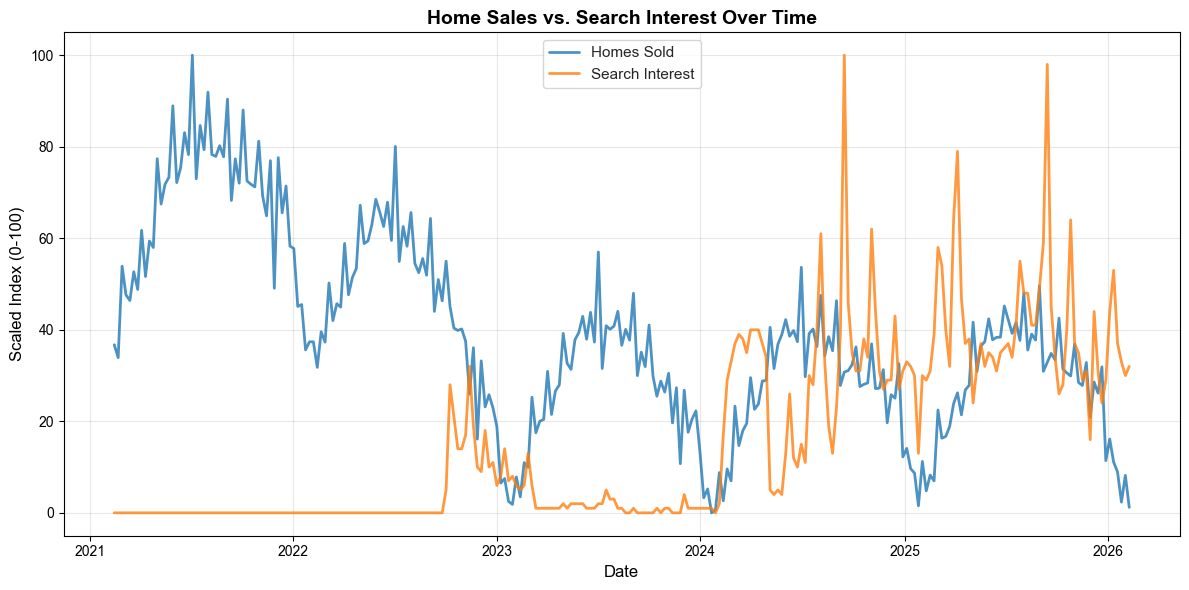

In [10]:
fig, ax = plot_time_series_comparison(
    df, 'week_end', 'homes_sold_scaled', 'search_interest',
    var1_label='Homes Sold', 
    var2_label='Search Interest',
    title='Home Sales vs. Search Interest Over Time'
)

It looks like we don't have enough search interest data to use data before about 2023, so let's narrow our window.

In [11]:
df = df[df['week_end'] >= '2023-02-01'].copy()

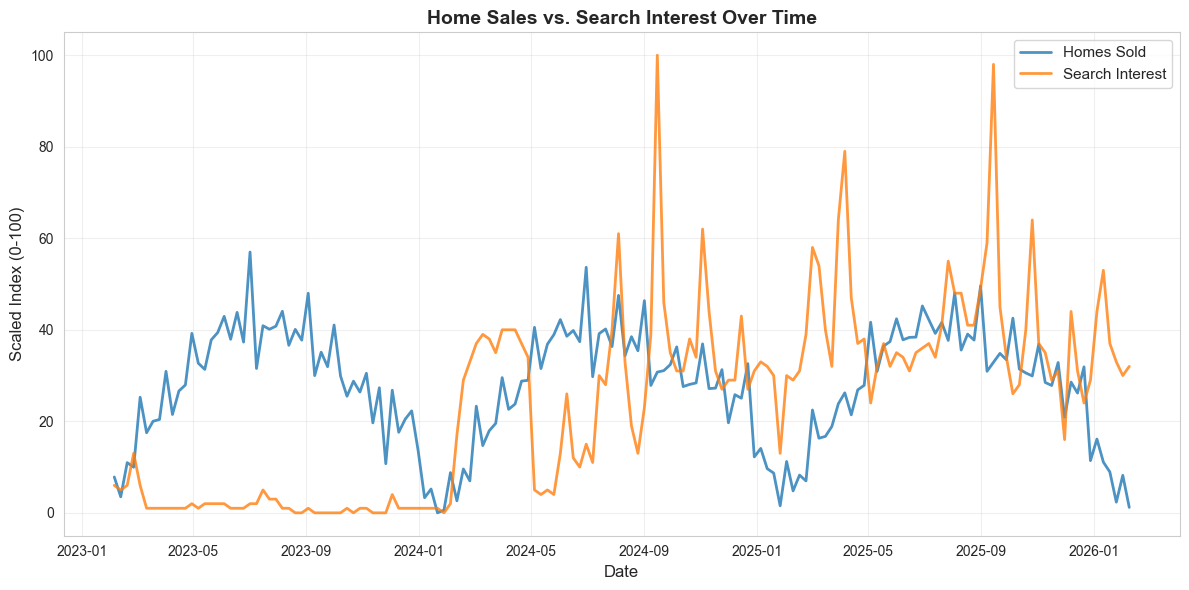

In [12]:
fig, ax = plot_time_series_comparison(
    df, 'week_end', 'homes_sold_scaled', 'search_interest',
    var1_label='Homes Sold', 
    var2_label='Search Interest',
    title='Home Sales vs. Search Interest Over Time'
)

## Statistical Analysis

Now we'll analyze the relationship between search interest and home sales using the approaches from:
- **Goel et al. (2010)**: Simple correlation and regression
- **Yang et al. (2015)**: Autoregressive models (ARGO approach)

In [13]:
# Fit simple linear regression model
# Following Goel et al. approach: Y = β₀ + β₁X + ε

# Prepare data
X = df[['search_interest']]
y = df['homes_sold_scaled']

# Add constant (intercept) to model
X_with_const = sm.add_constant(X)

# Fit OLS model
model_simple = sm.OLS(y, X_with_const).fit()

# Display results
print("=" * 70)
print("SIMPLE LINEAR REGRESSION: Home Sales ~ Search Interest")
print("=" * 70)
print(model_simple.summary())
print()

# Extract key statistics
print("\n" + "=" * 70)
print("KEY FINDINGS:")
print("=" * 70)
print(f"Intercept (β₀): {model_simple.params['const']:.3f}")
print(f"Slope (β₁): {model_simple.params['search_interest']:.3f}")
print(f"  → For every 1-point increase in search interest,")
print(f"     home sales increase by {model_simple.params['search_interest']:.3f} points (on 0-100 scale)")
print()
print(f"R-squared: {model_simple.rsquared:.4f}")
print(f"  → Search interest explains {model_simple.rsquared*100:.1f}% of variance in home sales")
print()
print(f"F-statistic: {model_simple.fvalue:.2f} (p = {model_simple.f_pvalue:.2e})")
print(f"  → Model is statistically significant")

SIMPLE LINEAR REGRESSION: Home Sales ~ Search Interest
                            OLS Regression Results                            
Dep. Variable:      homes_sold_scaled   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.04752
Date:                Mon, 16 Feb 2026   Prob (F-statistic):              0.828
Time:                        15:10:45   Log-Likelihood:                -622.70
No. Observations:                 158   AIC:                             1249.
Df Residuals:                     156   BIC:                             1256.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

### Autoregressive Model (Yang et al. ARGO Approach)

The key insight from Yang et al.'s ARGO paper: **recent past values are often the best predictor of near-future values**.

We'll compare:
1. **AR(1) Baseline**: Predict sales using only last week's sales
2. **ARGO**: Predict sales using last week's sales + search interest

Does search data improve predictions beyond simple autoregression?


In [14]:
# Create lagged variables: use last week's home sales to predict this week
df['homes_sold_lag1'] = df['homes_sold_scaled'].shift(1)

# Remove rows with NaN (first week)
df_ar = df[['homes_sold_scaled', 'homes_sold_lag1', 'search_interest']].dropna()

print("=" * 70)
print("AUTOREGRESSIVE MODELS")
print("=" * 70)
print(f"Using {len(df_ar)} weeks of data (after removing NaNs from lagging)")
print()

# Model 1: Just autoregression (AR baseline)
X_ar = df_ar[['homes_sold_lag1']]
y_ar = df_ar['homes_sold_scaled']
X_ar_const = sm.add_constant(X_ar)

model_ar = sm.OLS(y_ar, X_ar_const).fit()

print("\nMODEL 1: AR(1) Baseline - Sales(t) ~ Sales(t-1)")
print("-" * 70)
print(f"R-squared: {model_ar.rsquared:.4f}")
print(f"  → Last week's sales explain {model_ar.rsquared*100:.1f}% of this week's sales")
print()

# Model 2: Autoregression + Search Interest (ARGO approach)
X_argo = df_ar[['homes_sold_lag1', 'search_interest']]
X_argo_const = sm.add_constant(X_argo)

model_argo = sm.OLS(y_ar, X_argo_const).fit()

print("\nMODEL 2: ARGO - Sales(t) ~ Sales(t-1) + SearchInterest(t)")
print("-" * 70)
print(f"R-squared: {model_argo.rsquared:.4f}")
print(f"  → AR + Search explain {model_argo.rsquared*100:.1f}% of this week's sales")
print()

# Calculate improvement
r2_improvement = model_argo.rsquared - model_ar.rsquared
pct_improvement = (r2_improvement / model_ar.rsquared) * 100

print("\n" + "=" * 70)
print("DOES SEARCH DATA ADD PREDICTIVE POWER?")
print("=" * 70)
print(f"R² improvement: {r2_improvement:.4f}")
print(f"Percentage improvement: {pct_improvement:.1f}%")
print()

if r2_improvement > 0.01:
    print("✓ YES: Search interest significantly improves prediction")
    print(f"  Adding search data improves prediction by {pct_improvement:.1f}%")
else:
    print("✗ NO: Search interest adds minimal predictive power")
    print("  Autoregression alone is nearly as good")
    
print("\n" + "=" * 70)
print("ARGO MODEL DETAILS:")
print("=" * 70)
print(model_argo.summary())

AUTOREGRESSIVE MODELS
Using 157 weeks of data (after removing NaNs from lagging)


MODEL 1: AR(1) Baseline - Sales(t) ~ Sales(t-1)
----------------------------------------------------------------------
R-squared: 0.6086
  → Last week's sales explain 60.9% of this week's sales


MODEL 2: ARGO - Sales(t) ~ Sales(t-1) + SearchInterest(t)
----------------------------------------------------------------------
R-squared: 0.6092
  → AR + Search explain 60.9% of this week's sales


DOES SEARCH DATA ADD PREDICTIVE POWER?
R² improvement: 0.0006
Percentage improvement: 0.1%

✗ NO: Search interest adds minimal predictive power
  Autoregression alone is nearly as good

ARGO MODEL DETAILS:
                            OLS Regression Results                            
Dep. Variable:      homes_sold_scaled   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     120.0

In [15]:
# Home sales are highly seasonal (high in spring/summer, low in winter)
# Let's add seasonal controls to our model

# Create seasonal indicator variables
df['spring'] = ((df['week_end'].dt.month >= 3) & 
                (df['week_end'].dt.month <= 5)).astype(int)
df['summer'] = ((df['week_end'].dt.month >= 6) & 
                (df['week_end'].dt.month <= 8)).astype(int)
df['fall'] = ((df['week_end'].dt.month >= 9) & 
              (df['week_end'].dt.month <= 11)).astype(int)
# Winter (Dec-Feb) is the reference category

# Recreate lagged analysis with seasonal controls
df['homes_sold_lag1'] = df['homes_sold_scaled'].shift(1)
df_seasonal = df[['homes_sold_scaled', 'homes_sold_lag1', 'search_interest',
                   'spring', 'summer', 'fall']].dropna()

# Model 3: ARGO + Seasonal Controls
X_argo_seasonal = df_seasonal[['homes_sold_lag1', 'search_interest',
                                 'spring', 'summer', 'fall']]
y_seasonal = df_seasonal['homes_sold_scaled']
X_argo_seasonal_const = sm.add_constant(X_argo_seasonal)

model_argo_seasonal = sm.OLS(y_seasonal, X_argo_seasonal_const).fit()

print("=" * 70)
print("MODEL 3: ARGO + Seasonal Controls")
print("=" * 70)
print(f"R-squared: {model_argo_seasonal.rsquared:.4f}")
print()

# Compare to ARGO without seasonal controls
print(f"ARGO without seasons: R² = {model_argo.rsquared:.4f}")
print(f"ARGO with seasons:    R² = {model_argo_seasonal.rsquared:.4f}")
print(f"Improvement: {model_argo_seasonal.rsquared - model_argo.rsquared:.4f}")
print()

print("Seasonal coefficients:")
print(f"  Spring vs Winter: {model_argo_seasonal.params['spring']:.3f} " +
      f"(p={model_argo_seasonal.pvalues['spring']:.3f})")
print(f"  Summer vs Winter: {model_argo_seasonal.params['summer']:.3f} " +
      f"(p={model_argo_seasonal.pvalues['summer']:.3f})")
print(f"  Fall vs Winter:   {model_argo_seasonal.params['fall']:.3f} " +
      f"(p={model_argo_seasonal.pvalues['fall']:.3f})")
print()

print("Search interest coefficient:")
print(f"  Without seasonal controls: {model_argo.params['search_interest']:.3f}")
print(f"  With seasonal controls:    {model_argo_seasonal.params['search_interest']:.3f}")
print()

if abs(model_argo_seasonal.params['search_interest']) > abs(model_argo.params['search_interest']):
    print("→ Controlling for seasons makes search MORE important")
else:
    print("→ Some of search's predictive power was actually just seasonality")

MODEL 3: ARGO + Seasonal Controls
R-squared: 0.7126

ARGO without seasons: R² = 0.6092
ARGO with seasons:    R² = 0.7126
Improvement: 0.1034

Seasonal coefficients:
  Spring vs Winter: 10.515 (p=0.000)
  Summer vs Winter: 17.500 (p=0.000)
  Fall vs Winter:   11.087 (p=0.000)

Search interest coefficient:
  Without seasonal controls: 0.015
  With seasonal controls:    0.004

→ Some of search's predictive power was actually just seasonality


# Why Doesn't Search Predict Housing Better?

## Discuss:
1. What makes housing more like music than movies?
2. What would need to be true for search to predict housing sales better?
3. What would we predict INSTEAD of sales that might work better?

# More Discussion Questions

Based on your analysis, discuss the following:

## 1. Predictive Value
- How much variance in home sales can be explained by search interest alone?
- How does this compare to just using last week's sales (autoregression)?
- Does adding search data meaningfully improve predictions?

## 2. Temporal Dynamics
- Based on the ARGO model, do searches seem to happen BEFORE sales, AT THE SAME TIME, or AFTER?
- What does the coefficient on search interest tell us?
- How might you test different time lags?

## 3. Measurement Validity
- Does "mortgage rate" search volume actually capture housing market activity?
- Who might be over/under-represented in Google search data?
- What other search terms might be better predictors?

## 4. Comparison to Research Papers
- Goel et al. found search data worked well for movies/video games but not music. Why might that be?
- Yang et al. showed autoregression + search beat either alone for flu prediction. Did you find the same pattern?
- What does this tell us about when "digital trace data" is valuable for prediction?

## 5. Real-World Applications
- Who would benefit from predicting home sales? (Real estate companies? Government? Banks?)
- How accurate would predictions need to be to be useful?
- What could cause this prediction model to break down over time? (Think: Google Flu Trends failure)


# When is Search Data Predictive?

HIGH PREDICTIVE POWER:

- Short time lag: Search → Action within days
- Clear intent: Searching IS the start of the purchase action
- Discrete action: Single transaction, not ongoing behavior
- Limited alternatives: Searching Google is necessary part of process
- Measurable outcome: Can track actual sales/events

LOW PREDICTIVE POWER:

- Long time lag: Months between search and outcome
- Ambiguous intent: Just browsing, not buying
- Complex process: Multiple steps, many decision points
- Alternative discovery: Word-of-mouth, recommendations, habits
- Diffuse outcomes: Hard to measure the actual behavior

# What About other Time Lags?

Maybe search interest predicts sales but not right away?

In [16]:
# Create lagged search variables
# Positive shift = search happens BEFORE sales (leading indicator)
df['search_current'] = df['search_interest']                # Same week
df['search_lag_1week'] = df['search_interest'].shift(1)     # 1 week ago
df['search_lag_1month'] = df['search_interest'].shift(4)    # ~1 month ago (4 weeks)
df['search_lag_3months'] = df['search_interest'].shift(13)  # ~3 months ago (13 weeks)
df['search_lag_6months'] = df['search_interest'].shift(26)  # ~6 months ago (26 weeks)

# Test correlation at different lags
lags = {
    'Current week (0)': 'search_current',
    '1 week ago': 'search_lag_1week',
    '1 month ago (4 weeks)': 'search_lag_1month',
    '3 months ago (13 weeks)': 'search_lag_3months',
    '6 months ago (26 weeks)': 'search_lag_6months'
}

print("=" * 70)
print("CORRELATION AT DIFFERENT TIME LAGS")
print("=" * 70)
print(f"{'Lag Period':<30} {'Correlation':<15} {'Sample Size':<15}")
print("-" * 70)

lag_results = {}
for lag_name, lag_col in lags.items():
    # Calculate correlation (dropna to handle missing values from shift)
    valid_data = df[[lag_col, 'homes_sold_scaled']].dropna()
    if len(valid_data) > 0:
        corr = valid_data[lag_col].corr(valid_data['homes_sold_scaled'])
        lag_results[lag_name] = corr
        print(f"{lag_name:<30} {corr:>6.4f}        n={len(valid_data)}")
    else:
        print(f"{lag_name:<30} {'N/A':<15} (insufficient data)")

# Find best lag
best_lag = max(lag_results, key=lag_results.get)
print()
print(f"Strongest correlation at: {best_lag} (r = {lag_results[best_lag]:.4f})")

CORRELATION AT DIFFERENT TIME LAGS
Lag Period                     Correlation     Sample Size    
----------------------------------------------------------------------
Current week (0)               0.0175        n=158
1 week ago                     0.0189        n=157
1 month ago (4 weeks)          0.0428        n=154
3 months ago (13 weeks)        0.0437        n=145
6 months ago (26 weeks)        0.0097        n=132

Strongest correlation at: 3 months ago (13 weeks) (r = 0.0437)


In [17]:
# Compare predictive power at different lags
results_list = []

for lag_name, lag_col in lags.items():
    # Prepare data (drop NaN from shift)
    analysis_df = df[['homes_sold_scaled', lag_col]].dropna()
    
    if len(analysis_df) > 30:  # Need enough data
        X = sm.add_constant(analysis_df[[lag_col]])
        y = analysis_df['homes_sold_scaled']
        
        model = sm.OLS(y, X).fit()
        
        results_list.append({
            'Lag': lag_name,
            'R²': model.rsquared,
            'Coefficient': model.params[lag_col],
            'P-value': model.pvalues[lag_col],
            'N': len(analysis_df)
        })

results_df = pd.DataFrame(results_list)

print("\n" + "=" * 70)
print("REGRESSION RESULTS AT DIFFERENT LAGS")
print("=" * 70)
print(results_df.to_string(index=False))


REGRESSION RESULTS AT DIFFERENT LAGS
                    Lag       R²  Coefficient  P-value   N
       Current week (0) 0.000305     0.010570 0.827721 158
             1 week ago 0.000359     0.011380 0.813914 157
  1 month ago (4 weeks) 0.001836     0.025139 0.597743 154
3 months ago (13 weeks) 0.001909     0.025761 0.601789 145
6 months ago (26 weeks) 0.000093     0.005972 0.912409 132


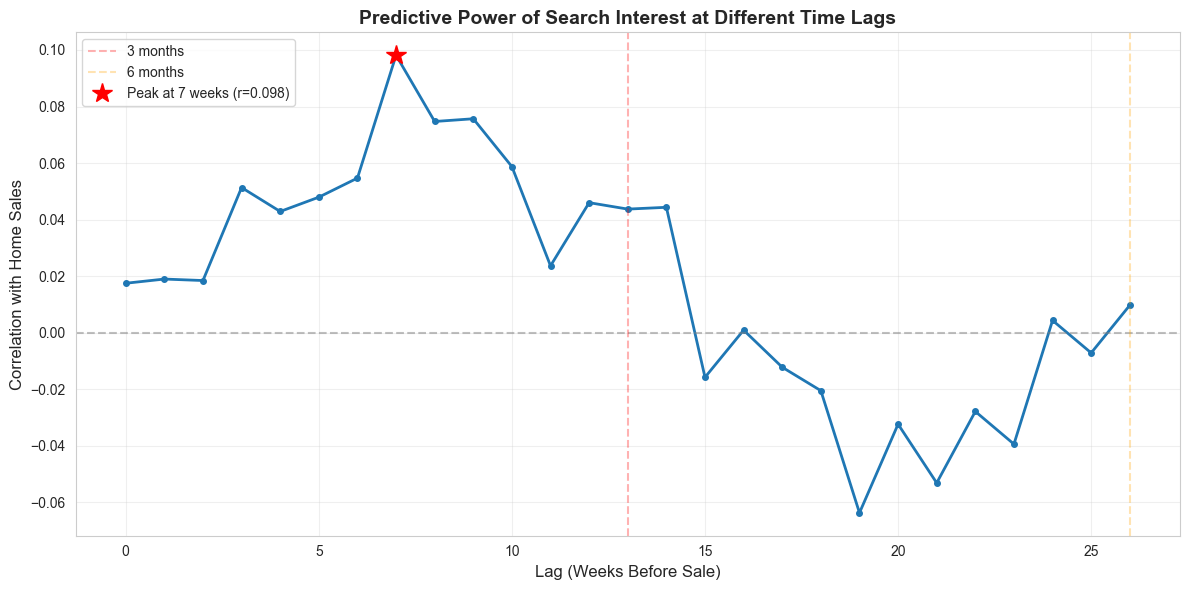


Peak correlation occurs at 7 week(s) lag
Correlation strength: r = 0.0982


In [18]:
# Plot correlation strength across different lags
import matplotlib.pyplot as plt
import numpy as np

# Test many lags (0 to 26 weeks)
lag_weeks = range(0, 27)
correlations = []

for lag in lag_weeks:
    df[f'temp_lag_{lag}'] = df['search_interest'].shift(lag)
    valid = df[[f'temp_lag_{lag}', 'homes_sold_scaled']].dropna()
    if len(valid) > 30:
        corr = valid[f'temp_lag_{lag}'].corr(valid['homes_sold_scaled'])
        correlations.append(corr)
    else:
        correlations.append(np.nan)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(lag_weeks, correlations, marker='o', linewidth=2, markersize=4)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=13, color='red', linestyle='--', alpha=0.3, label='3 months')
ax.axvline(x=26, color='orange', linestyle='--', alpha=0.3, label='6 months')

ax.set_xlabel('Lag (Weeks Before Sale)', fontsize=12)
ax.set_ylabel('Correlation with Home Sales', fontsize=12)
ax.set_title('Predictive Power of Search Interest at Different Time Lags', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Mark the peak
peak_lag = np.nanargmax(correlations)
peak_corr = correlations[peak_lag]
ax.plot(peak_lag, peak_corr, 'r*', markersize=15, 
        label=f'Peak at {peak_lag} weeks (r={peak_corr:.3f})')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nPeak correlation occurs at {peak_lag} week(s) lag")
print(f"Correlation strength: r = {peak_corr:.4f}")

In [19]:
# Best ARGO model: Which lag of search works best with autoregression?

df['homes_sold_lag1'] = df['homes_sold_scaled'].shift(1)

# Test ARGO with different search lags
argo_results = []

for lag_name, lag_col in lags.items():
    df_test = df[['homes_sold_scaled', 'homes_sold_lag1', lag_col]].dropna()
    
    if len(df_test) > 30:
        X = sm.add_constant(df_test[['homes_sold_lag1', lag_col]])
        y = df_test['homes_sold_scaled']
        
        model = sm.OLS(y, X).fit()
        
        argo_results.append({
            'Search Lag': lag_name,
            'R²': model.rsquared,
            'Search Coefficient': model.params[lag_col],
            'Search P-value': model.pvalues[lag_col]
        })

argo_df = pd.DataFrame(argo_results)

print("=" * 70)
print("ARGO MODEL WITH DIFFERENT SEARCH LAGS")
print("=" * 70)
print(argo_df.to_string(index=False))

ARGO MODEL WITH DIFFERENT SEARCH LAGS
             Search Lag       R²  Search Coefficient  Search P-value
       Current week (0) 0.609164            0.014657        0.629764
             1 week ago 0.608572            0.000595        0.984371
  1 month ago (4 weeks) 0.592016           -0.002575        0.932941
3 months ago (13 weeks) 0.606325            0.002389        0.938844
6 months ago (26 weeks) 0.620368            0.001639        0.961078


### Time Lag Analysis Results

**What we found:**
- Strongest correlation at: ___ week lag
- By 3 months lag: r = ___
- By 6 months lag: r = ___

#### Discuss
1. Why does correlation decline as lag increases?
2. What does this tell us about the housing decision timeline?
3. Compare to movies - why is housing different?
4. Does this support or challenge the idea that search predicts sales?

If search "predicted" home purchases, we'd expect:
- Strong correlation at 3-6 month lag (time to buy after searching)
- But we find the opposite - correlation weakens!
- This suggests: Search and sales are COINCIDENT, not predictive
- Both are driven by the same seasonal/economic factors